# Averaged Cospectra

Let's look at how averaged cospectra work.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack

from stingray import Lightcurve, Crossspectrum


/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:20: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


In [2]:
npoints = 100000

time = np.linspace(0, 10, npoints)

counts1 = np.random.poisson(10, time.shape[0])  
counts2 = np.random.poisson(10, time.shape[0])  

lc1 = Lightcurve(time, counts1)
lc2 = Lightcurve(time, counts2)

In [3]:
from stingray import AveragedCrossspectrum

In [4]:
cs_noavg = Crossspectrum(lc1, lc2, norm="leahy")
cs2 = AveragedCrossspectrum(lc1, lc2, segment_size=5.0, norm="leahy")
cs3 = AveragedCrossspectrum(lc1, lc2, segment_size=3.3, norm="leahy")
cs4 = AveragedCrossspectrum(lc1, lc2, segment_size=2.5, norm="leahy")
cs10 = AveragedCrossspectrum(lc1, lc2, segment_size=1.0, norm="leahy")
cs100 = AveragedCrossspectrum(lc1, lc2, segment_size=0.1, norm="leahy")

/Users/danielahuppenkothen/work/repositories/stingraysoftware/stingray/stingray/utils.py:60: UserWarning: SIMON says: Errorbars on cross spectra are not thoroughly tested. Please report any inconsistencies.
  warnings.warn("SIMON says: {0}".format(message), **kwargs)


Let's do this by hand, just to check:

In [5]:
lc1_seg1 = lc1.counts[:int(npoints/2)]
lc2_seg1 = lc2.counts[:int(npoints/2)]

lc1_seg2 = lc1.counts[int(npoints/2):]
lc2_seg2 = lc2.counts[int(npoints/2):]

In [6]:
fourier1_seg1 = scipy.fftpack.fft(lc1_seg1)
fourier2_seg1 = scipy.fftpack.fft(lc2_seg1)

fourier1_seg2 = scipy.fftpack.fft(lc1_seg2)
fourier2_seg2 = scipy.fftpack.fft(lc2_seg2)

freqs = scipy.fftpack.fftfreq(int(npoints/2), lc1.dt)

fourier1_seg1 = fourier1_seg1[freqs>0]
fourier2_seg1 = fourier2_seg1[freqs>0]

fourier1_seg2 = fourier1_seg2[freqs>0]
fourier2_seg2 = fourier2_seg2[freqs>0]

In [7]:
csd1 = (fourier1_seg1.real*fourier2_seg1.real + fourier1_seg1.imag*fourier2_seg1.imag)
csd2 = (fourier1_seg2.real*fourier2_seg2.real + fourier1_seg2.imag*fourier2_seg2.imag)

In [8]:
mean_nphot1 = np.sqrt(np.sum(lc1_seg1)*np.sum(lc2_seg1))
mean_nphot2 = np.sqrt(np.sum(lc1_seg2)*np.sum(lc2_seg2))

In [9]:
csd1_normed = 2*csd1/mean_nphot1
csd2_normed = 2*csd2/mean_nphot2

Let's define the Laplace probability distribution:

In [10]:
import scipy.stats

In [11]:
x = np.linspace(-10, 10, 1000)

lapl = scipy.stats.laplace(0,1)

lapl_prob = lapl.pdf(x)

<IPython.core.display.Javascript object>


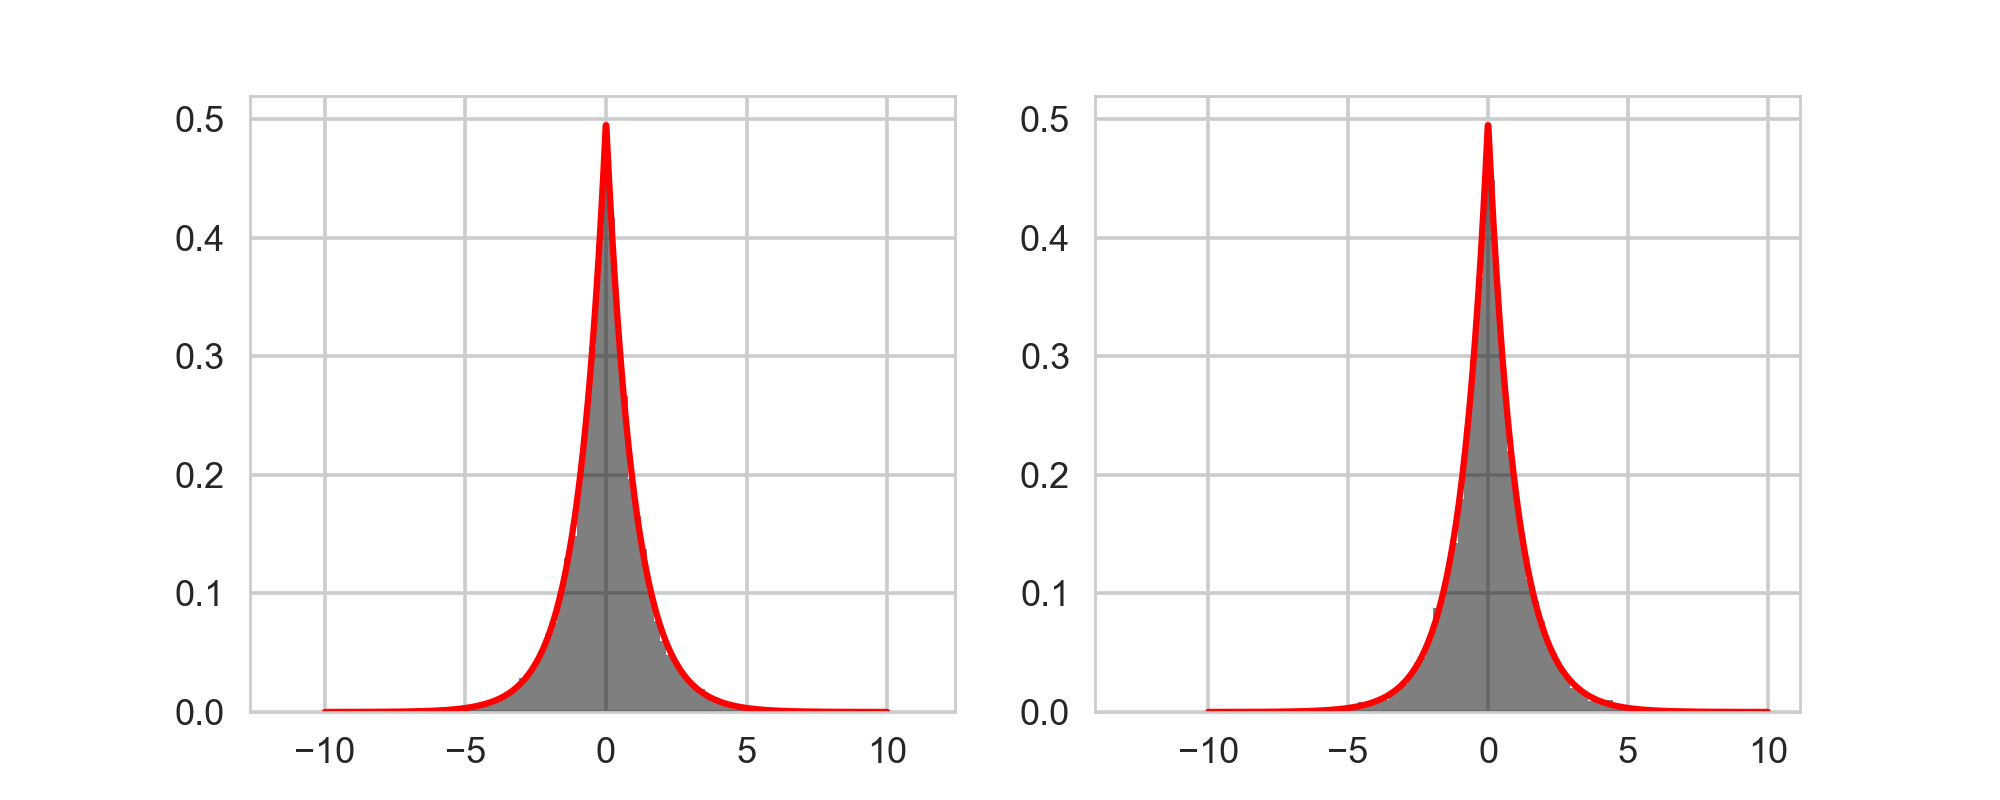

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.hist(csd1_normed, bins=100, histtype="stepfilled", 
         color="black", alpha=0.5, normed=True)
ax1.plot(x, lapl_prob, color="red")
ax2.hist(csd2_normed, bins=100, histtype="stepfilled", 
         color="black", alpha=0.5, normed=True)
ax2.plot(x, lapl_prob, color="red")



In [13]:
csd_sum = (csd1_normed + csd2_normed)

We define two Gaussian distributions. One with a width of 2 and one with a width that Matteo figured out:

In [14]:
gauss_small = scipy.stats.norm(0, 2.0)
gauss = scipy.stats.norm(0, np.sqrt(2)/np.sqrt(2+1))

<IPython.core.display.Javascript object>


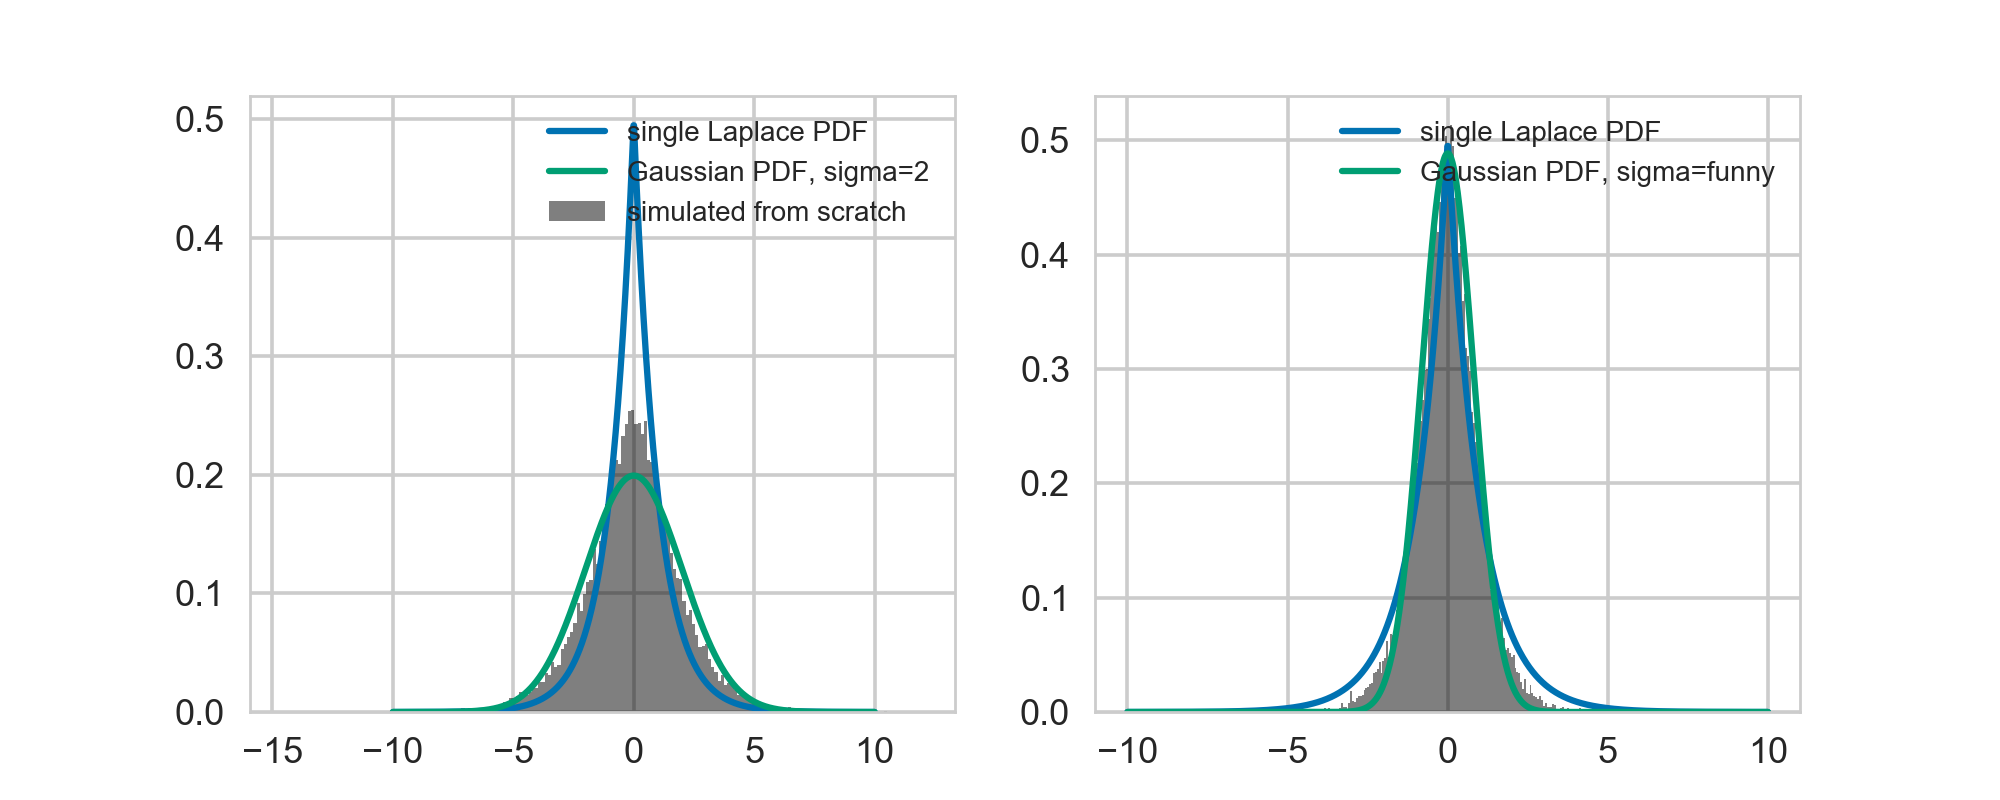

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.hist(csd_sum, bins=200, color="black", histtype="stepfilled", 
         alpha=0.5, normed=True, label="simulated from scratch")

ax1.plot(x, lapl_prob, label="single Laplace PDF")
ax1.plot(x, gauss_small.pdf(x), label="Gaussian PDF, sigma=2")
ax1.legend(prop={"size":10})

ax2.hist(cs2.power, bins=200, color="black", histtype="stepfilled", alpha=0.5, normed=True)
ax2.plot(x, lapl_prob, label="single Laplace PDF")
ax2.plot(x, gauss.pdf(x),  label="Gaussian PDF, sigma=funny")
ax2.legend(prop={"size":10})



In [16]:
npoints

100000

In [17]:
def simulate_averaged_cospectrum(nspectra, npoints=10000, tseg=10):

    lc1_all = []
    lc2_all = []
    
    time = np.linspace(0, tseg, npoints)

    for i in range(nspectra):

        counts1 = np.random.poisson(10, time.shape[0])  
        counts2 = np.random.poisson(10, time.shape[0])  

        lc1 = Lightcurve(time, counts1)
        lc2 = Lightcurve(time, counts2)
        
        fourier1 = scipy.fftpack.fft(lc1.counts)
        fourier2 = scipy.fftpack.fft(lc2.counts)
        
        freqs = scipy.fftpack.fftfreq(int(npoints), lc1.dt)

        fourier1 = fourier1[freqs>0]
        fourier2 = fourier2[freqs>0]
        
        freqs = freqs[freqs>0]
        
        csd = (fourier1.real*fourier2.real + fourier1.imag*fourier2.imag)
        
        mean_nphot = np.sqrt(np.sum(lc1.counts)*np.sum(lc2.counts))
        
        csd_normed = 2*csd/mean_nphot
        
        if i == 0:
            csd_sum = csd_normed
            
        else:
            csd_sum += csd_normed
            
    csd_sum /= nspectra
    return freqs, csd_sum


In [18]:
freqs2, cs2_new = simulate_averaged_cospectrum(2, 100000)

In [19]:
freqs3, cs3_new = simulate_averaged_cospectrum(3, 100000)

In [20]:
freqs4, cs4_new = simulate_averaged_cospectrum(4, 100000)

In [21]:
freqs10, cs10_new = simulate_averaged_cospectrum(10, 100000)

In [22]:
freqs20, cs20_new = simulate_averaged_cospectrum(20, 100000)

In [23]:
freqs30, cs30_new = simulate_averaged_cospectrum(30, 100000)

In [24]:
freqs100, cs100_new = simulate_averaged_cospectrum(100, 100000)

In [25]:
len(freqs100)

49999

In [26]:
len(cs100_new)

49999

<IPython.core.display.Javascript object>


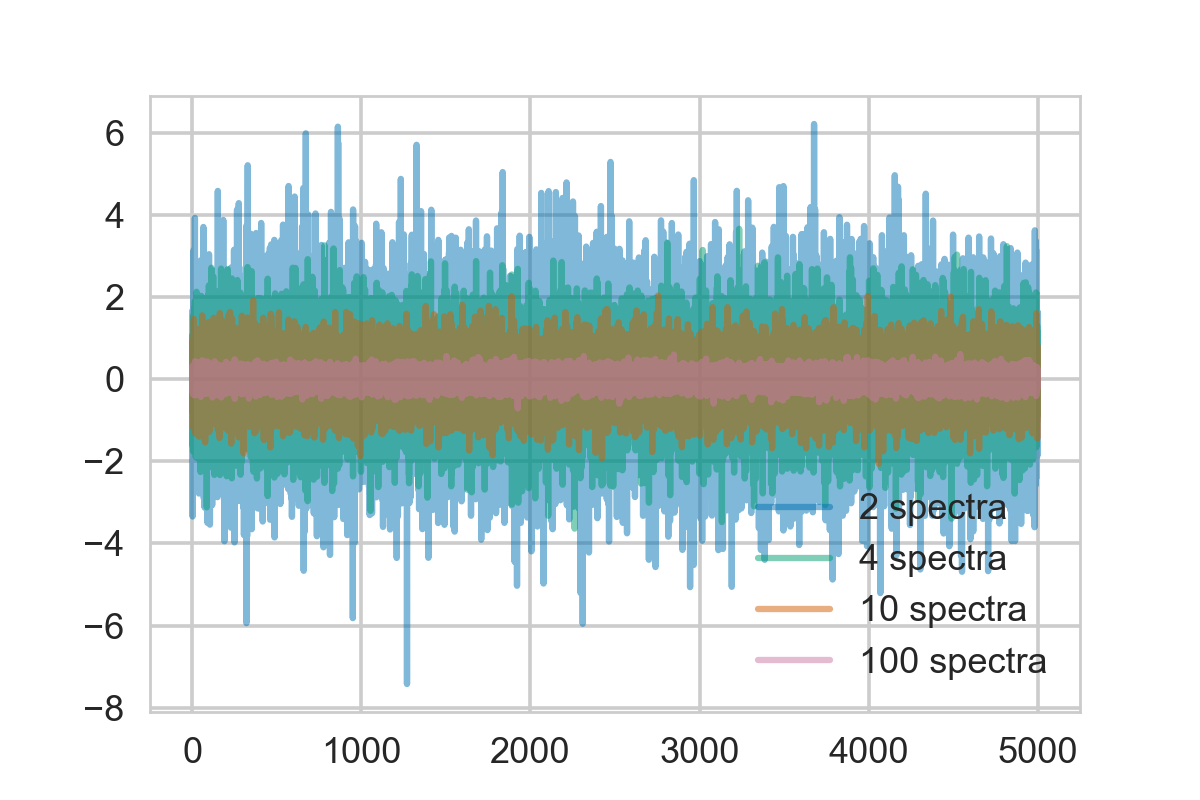

In [27]:
plt.figure(figsize=(6,4))
plt.plot(freqs2[freqs2>0], cs2_new, alpha=0.5, label="2 spectra")
plt.plot(freqs4[freqs4>0], cs4_new, alpha=0.5, label="4 spectra")
plt.plot(freqs10[freqs10>0], cs10_new, alpha=0.5, label="10 spectra")
plt.plot(freqs100[freqs100>0], cs100_new, alpha=0.5, label="100 spectra")

plt.legend()

<IPython.core.display.Javascript object>


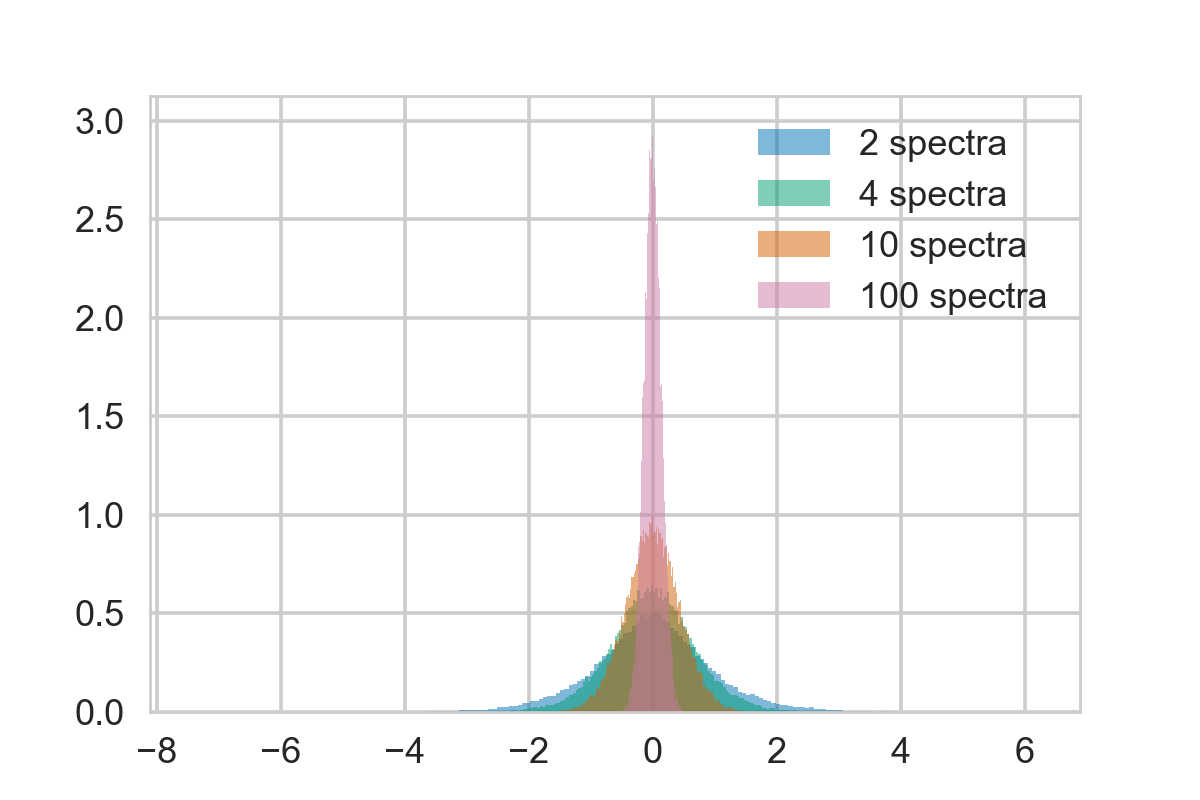

In [28]:
plt.figure(figsize=(6,4))
plt.hist(cs2_new, bins=200, normed=True, alpha=0.5, label="2 spectra")
plt.hist(cs4_new, bins=200, normed=True, alpha=0.5, label="4 spectra")
plt.hist(cs10_new, bins=200, normed=True, alpha=0.5, label="10 spectra")
plt.hist(cs100_new, bins=200, normed=True, alpha=0.5, label="100 spectra")

plt.legend()

Let's do the same with the power spectra I simulated using the `Crossspectrum` class:

<IPython.core.display.Javascript object>


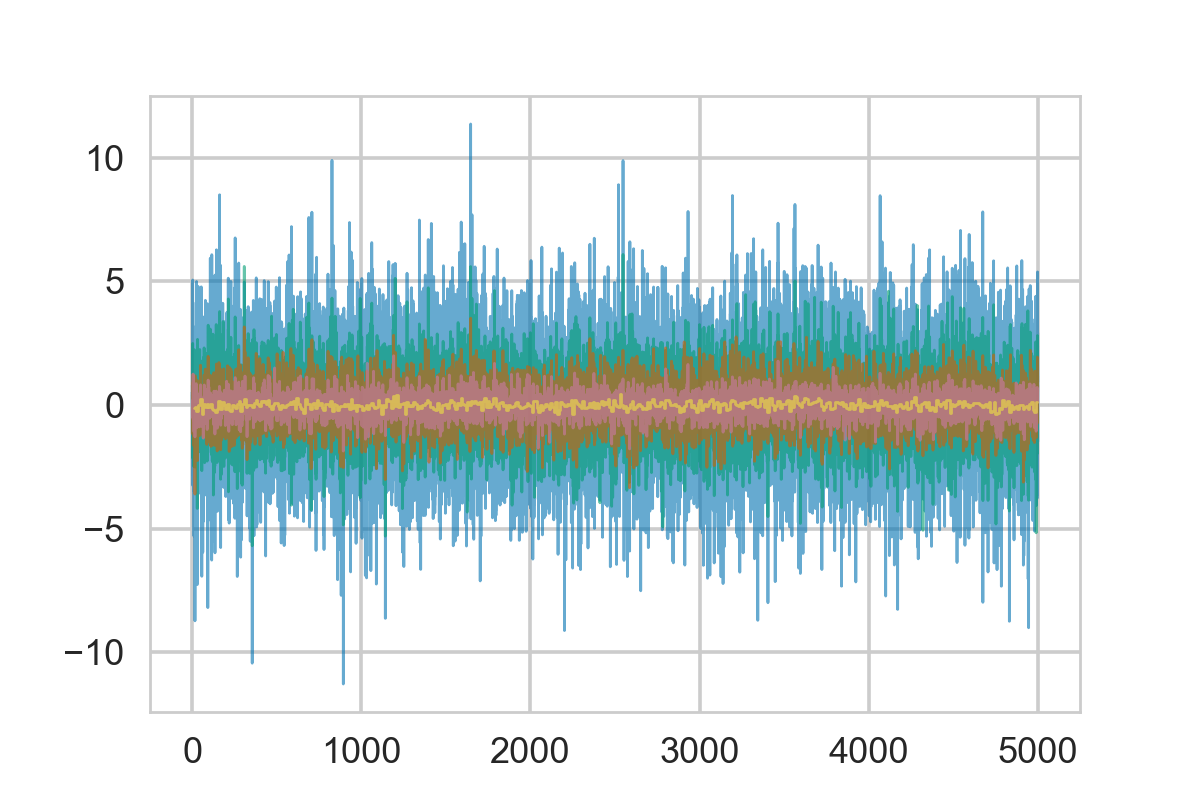

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(cs_noavg.freq, cs_noavg.power, lw=1, alpha=0.6, linestyle="steps-mid", label="not averaged")
ax.plot(cs2.freq, cs2.power, lw=1, alpha=0.6, linestyle="steps-mid", label="2 averaged")
ax.plot(cs4.freq, cs4.power, lw=1, alpha=0.6, linestyle="steps-mid", label="4 averaged")
ax.plot(cs10.freq, cs10.power, lw=1, alpha=0.6, linestyle="steps-mid", label="10 averaged")
ax.plot(cs100.freq, cs100.power, lw=1, alpha=0.6, linestyle="steps-mid", label="100 averaged")

Let's plot the distribution along with a Laplacian:

<IPython.core.display.Javascript object>


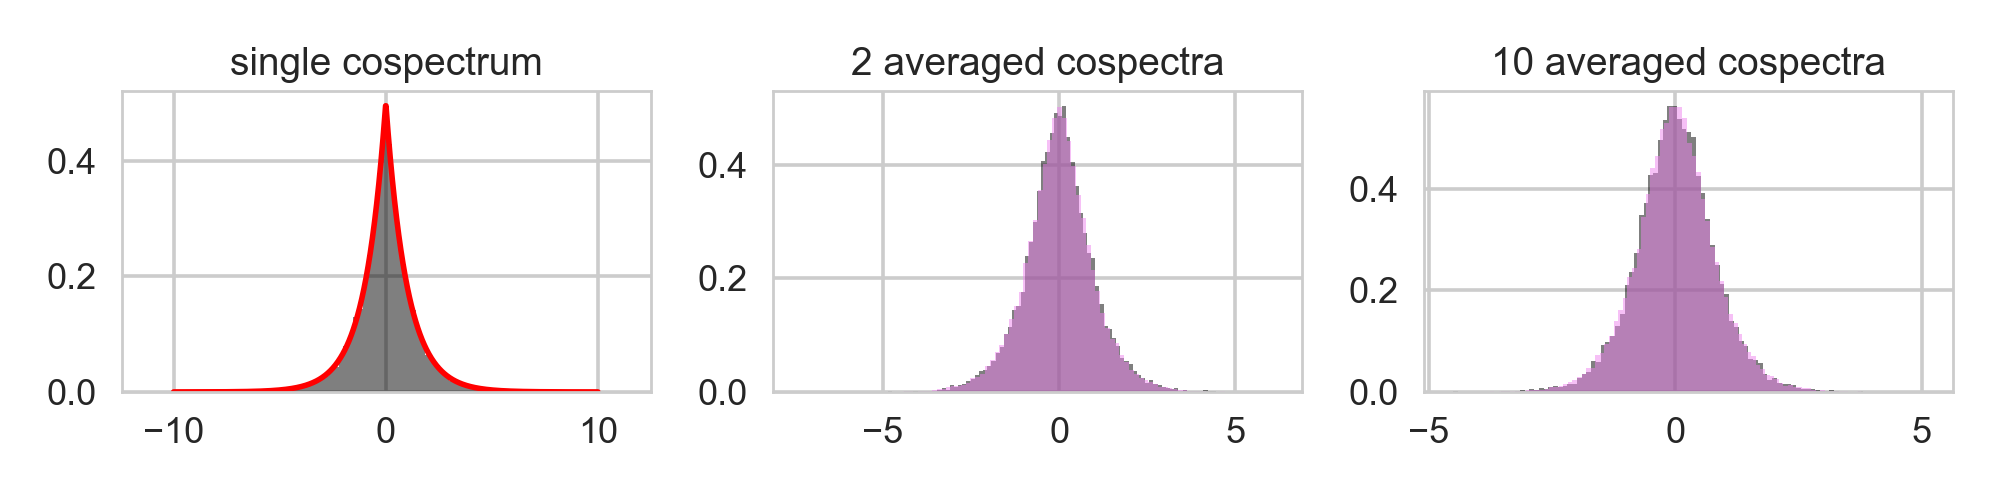

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 2.5))
ax1.hist(cs_noavg.power, bins=100, normed=True, histtype='stepfilled', color="black", alpha=0.5)
ax1.set_title("single cospectrum", size=14)
ax1.plot(x, lapl_prob, lw=2, color="red")

ax2.hist(cs2.power, bins=100, normed=True, histtype='stepfilled', color="black", alpha=0.5)
ax2.hist(cs2_new, bins=100, normed=True, histtype='stepfilled', color="violet", alpha=0.5)
ax2.set_title("2 averaged cospectra", size=14)

ax3.hist(cs3.power, bins=100, normed=True, histtype='stepfilled', color="black", alpha=0.5)
ax3.set_title("10 averaged cospectra", size=14)
ax3.hist(cs3_new, bins=100, normed=True, histtype='stepfilled', color="violet", alpha=0.5)


#ax4.hist(cs100.power, bins=100, normed=True, histtype='stepfilled', color="black", alpha=0.5)
#ax4.hist(cs100_new, bins=100, normed=True, histtype='stepfilled', color="violet", alpha=0.5)
#ax4.set_title("100 averaged cospectra", size=14)

plt.tight_layout()

Okay, it looks like my manual calculation and the Crossspectrum class results match up! That's good!

For a single co-spectrum the probability distribution is Laplacian (shown in red). For averaged cospectra, the situation is a little more complex. 

We're going to define our probability distribution, equation 2.3.24 in [this paper](http://www.springer.com/us/book/9780817641665):

In [31]:
import scipy.misc

In [32]:
def averaged_cospectra_pdf(x, n):
    absnx = np.abs(n*x)
    prefac_bottom1 = scipy.misc.factorial(n-1)
    prefac_bottom2 = 2.0**n
    
    numerical_prefac = n/(prefac_bottom1*prefac_bottom2)
    prefac = numerical_prefac * np.exp(-absnx)
    
    #print("prefac factorial: " + str(prefac_bottom1))
    #print("prefac 2**n: " + str(prefac_bottom2))
    #print("numerical prefac: " + str(numerical_prefac))
    
    sum_all = np.zeros_like(x)
    for j in range(n):
        inside1 = n-1+j
        sum_factorial_top = scipy.misc.factorial(inside1)
        #print("sum factorial top: " + str(sum_factorial_top))
        
        inside2 = n - 1 - j
        sum_factorial_bottom = scipy.misc.factorial(inside2)
        #print("sum factorial bottom:" + str(sum_factorial_bottom))
        
        sum_factorial_bottom2 = scipy.misc.factorial(j)
        #print("sum factorial bottom2: " + str(sum_factorial_bottom2))
        
        sum_bin_factor = 2.0**j
        #print("sum binary factor: " + str(sum_bin_factor))
        
        exponent = n - 1 - j
        #print("exponent: " + str(exponent))
        
        exp_factor = absnx**exponent
        
        sum_all += (sum_factorial_top/(sum_factorial_bottom*sum_factorial_bottom2) * (exp_factor/sum_bin_factor))
        
    return sum_all*prefac

In [33]:
cs2_prob = averaged_cospectra_pdf(x, 2)
cs3_prob = averaged_cospectra_pdf(x, 3)

cs4_prob = averaged_cospectra_pdf(x, 4)
cs10_prob = averaged_cospectra_pdf(x, 10)
cs20_prob = averaged_cospectra_pdf(x, 20)
cs30_prob = averaged_cospectra_pdf(x, 30)

cs100_prob = averaged_cospectra_pdf(x, 100)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in multiply


In the paper, there are the equations for the first four $n$, so let's code these explicitly and compare:

In [34]:
def laplace1(x):
    absx = np.abs(x)
    return 0.5 * np.exp(-absx)

def laplace2(x):
    absx = np.abs(x)
    fac1 = 1.0 + 2. * absx
    fac2 = np.exp(-2.*absx)
    return 0.5 * fac1 * fac2

def laplace3(x):
    absx = np.abs(x)
    fac1 = 9.0/16.0
    fac2 = 1.0 + 3.0 * absx + 3.0 * absx**2.0
    fac3 = np.exp(-3.0 * absx)
    return fac1 * fac2 * fac3

def laplace4(x):
    absx = np.abs(x)
    fac1 = 1.0/24.0
    fac2 = 15.0 + 60.0*absx + 96 * absx**2.0 + 64 * absx**3.0
    fac3 = np.exp(-4.0 * absx)
    return fac1 * fac2 * fac3

In [35]:
lapl2_manual = laplace2(x)
lapl3_manual = laplace3(x)
lapl4_manual = laplace4(x)

In [36]:
gauss = scipy.stats.norm(0, np.sqrt(2)/np.sqrt(100+1))

gauss100 = gauss.pdf(x)

In [37]:
len(cs_noavg.power)

49999

In [38]:
len(cs100_new)

49999

<IPython.core.display.Javascript object>


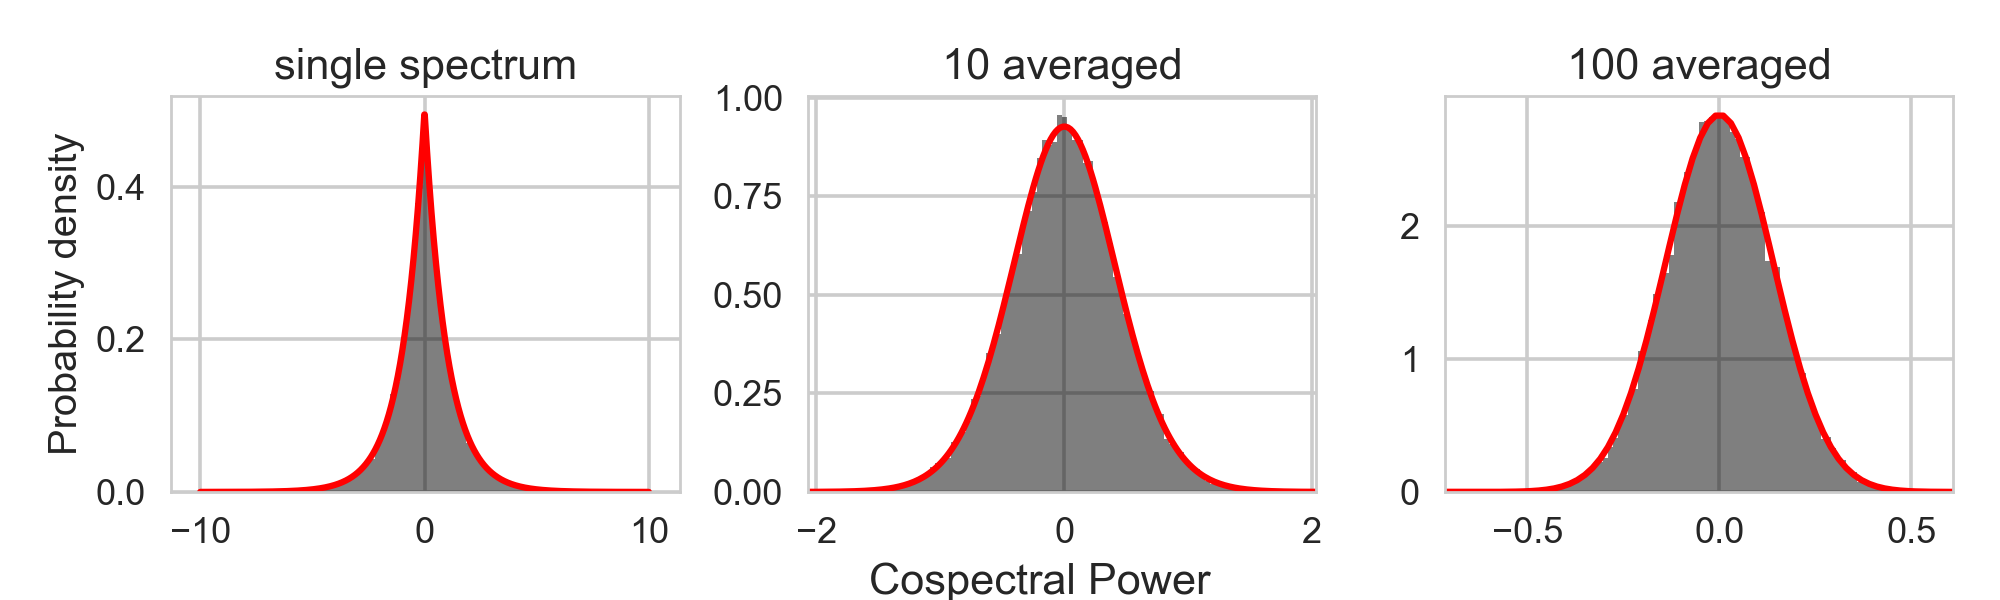

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

cs_new_all = [cs_noavg.power, cs10_new, cs100_new]

label_all = ["single spectrum", "10 averaged", "100 averaged"]

prob_all = [lapl_prob, cs10_prob, gauss100]

axes = np.hstack(axes)

for i in range(len(cs_new_all)):
    axes[i].hist(cs_new_all[i], bins=100, normed=True, histtype="stepfilled", color="black", alpha=0.5)
    axes[i].plot(x, prob_all[i], color="red")
    axes[i].set_title(label_all[i])
    axes[i].set_xlim(np.min(cs_new_all[i]), np.max(cs_new_all[i]))

fig.text(0.52, 0.01, 'Cospectral Power', ha='center')
axes[0].set_ylabel("Probability density")

plt.tight_layout()

plt.savefig("../paper/avg_dist.png", format="png")


<IPython.core.display.Javascript object>


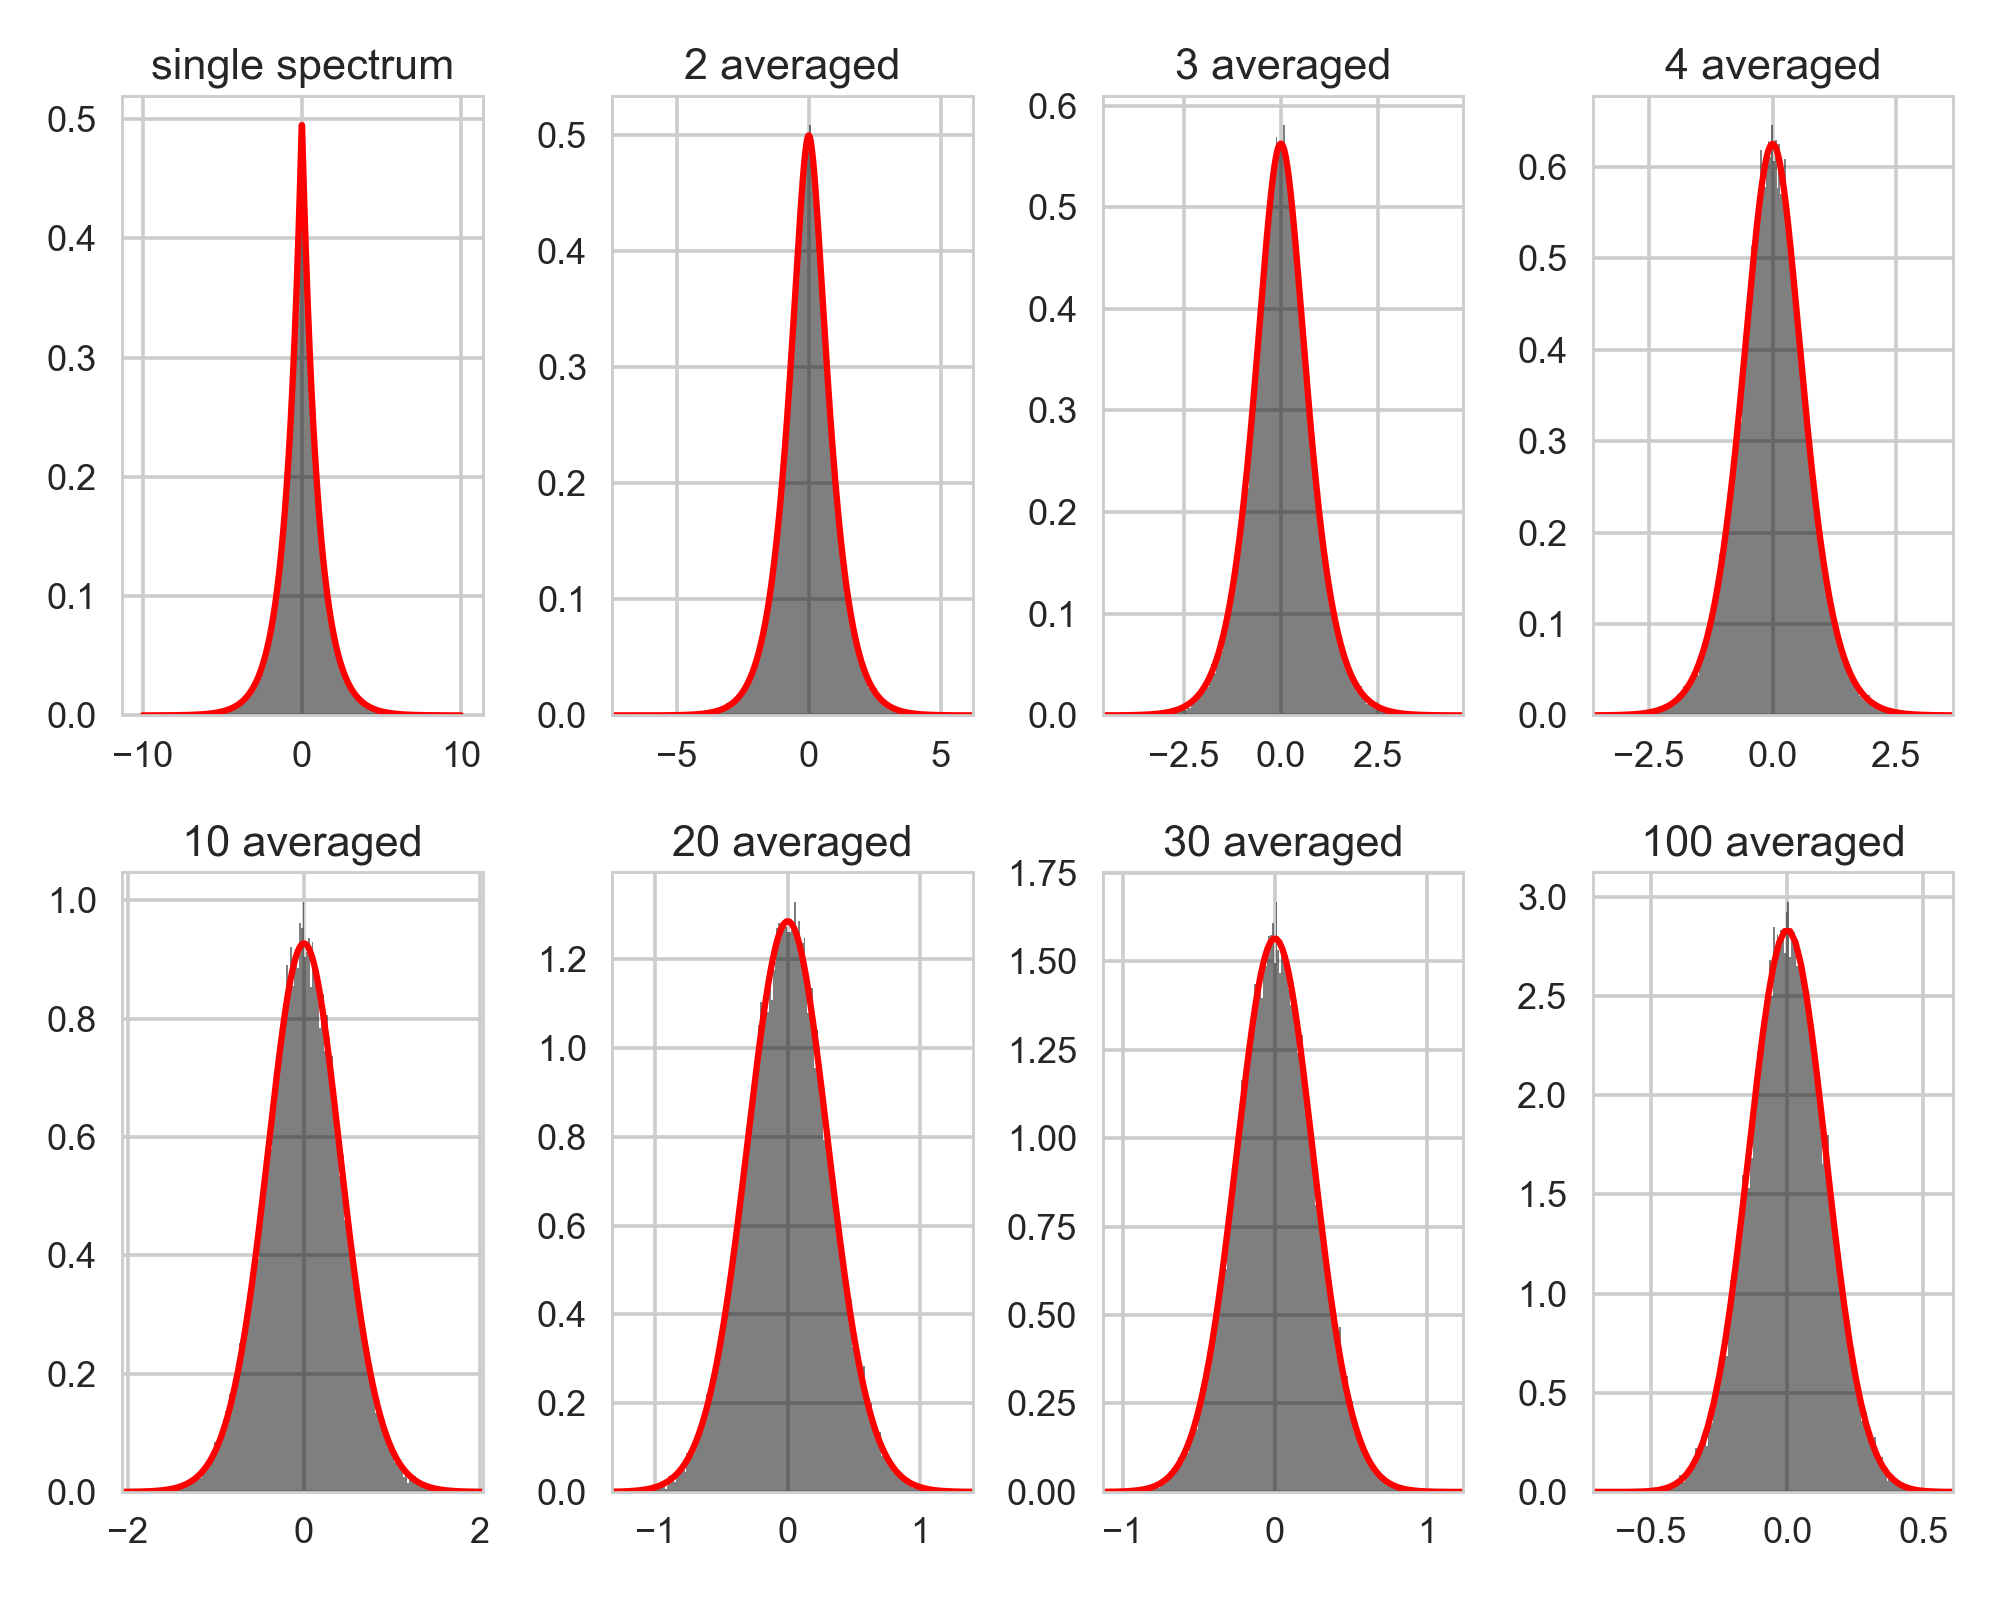

In [40]:
fig, axes = plt.subplots(2, 4, figsize=(10, 8))

cs_new_all = [cs_noavg.power, cs2_new, cs3_new, cs4_new, cs10_new, cs20_new, cs30_new, cs100_new]

label_all = ["single spectrum", "2 averaged", "3 averaged", "4 averaged", "10 averaged", 
             "20 averaged", "30 averaged", "100 averaged"]

prob_all = [lapl_prob, cs2_prob, cs3_prob, cs4_prob, cs10_prob, cs20_prob, cs30_prob, gauss100]

axes = np.hstack(axes)

for i in range(len(cs_new_all)):
    axes[i].hist(cs_new_all[i], bins=200, normed=True, histtype="stepfilled", color="black", alpha=0.5)
    axes[i].plot(x, prob_all[i], color="red")
    axes[i].set_title(label_all[i])
    axes[i].set_xlim(np.min(cs_new_all[i]), np.max(cs_new_all[i]))
    
plt.tight_layout()



Hooray! It works! 

In the plot above, the distribution for the single cospectrum is modelled by a simple Laplacian (in red). For 2 - 30 averaged cospectra, I've used the probability distribution above to compute the PDF (also in red). For many averaged spectra, the exponents and factorials in the equation get very large, and so the code will break due to numerical errors. In this limit, I've modelled the distribution with a Gaussian, which seems to work pretty well (see also the other notebook for effects this assumption has on p-values derived for outliers).

So in principle, I can use this as a likelihood. The question is, in order to find QPOs, I need to compute the CDF, so integrate, which may be hard, because it involves integrals over sums and factorials. 

### The CDF for the Laplacian PDF

We defined this in the paper, so let's write a numerical version here.

In [41]:
def averaged_cospectra_cdf(xcoord, n):
    cdf = np.zeros_like(xcoord)

    for i,x in enumerate(xcoord):
        prefac_bottom1 = scipy.misc.factorial(n-1)
        
        for j in range(n):
            prefac_top = n * scipy.misc.factorial(n-1+j)
            prefac_bottom2 = scipy.misc_factorial(n-1-j) * scipy.misc.factorial(j)
            prefac_bottom3 = 2.0**(n+j)
            
            prefac = prefac_top / (prefac_bottom1 * prefac_bottom2 * prefac_bottom3)
            
            if x >= 0:
                first_fac = 2.0*scipy.special.gamma(-j + n)
                second_fac = scipy.special.gammaincc(-j+n, n*x) * first_fac
                fac = first_fac + second_fac
            else:
                fac = scipy.special.gammaincc(-j+n, n*x) * first_fac
                
            cdf[i] += (prefac * fac)
                
    return cdf
        

Let's make some more simulations:

In [42]:
length = 1000000
dt = 0.5

<IPython.core.display.Javascript object>


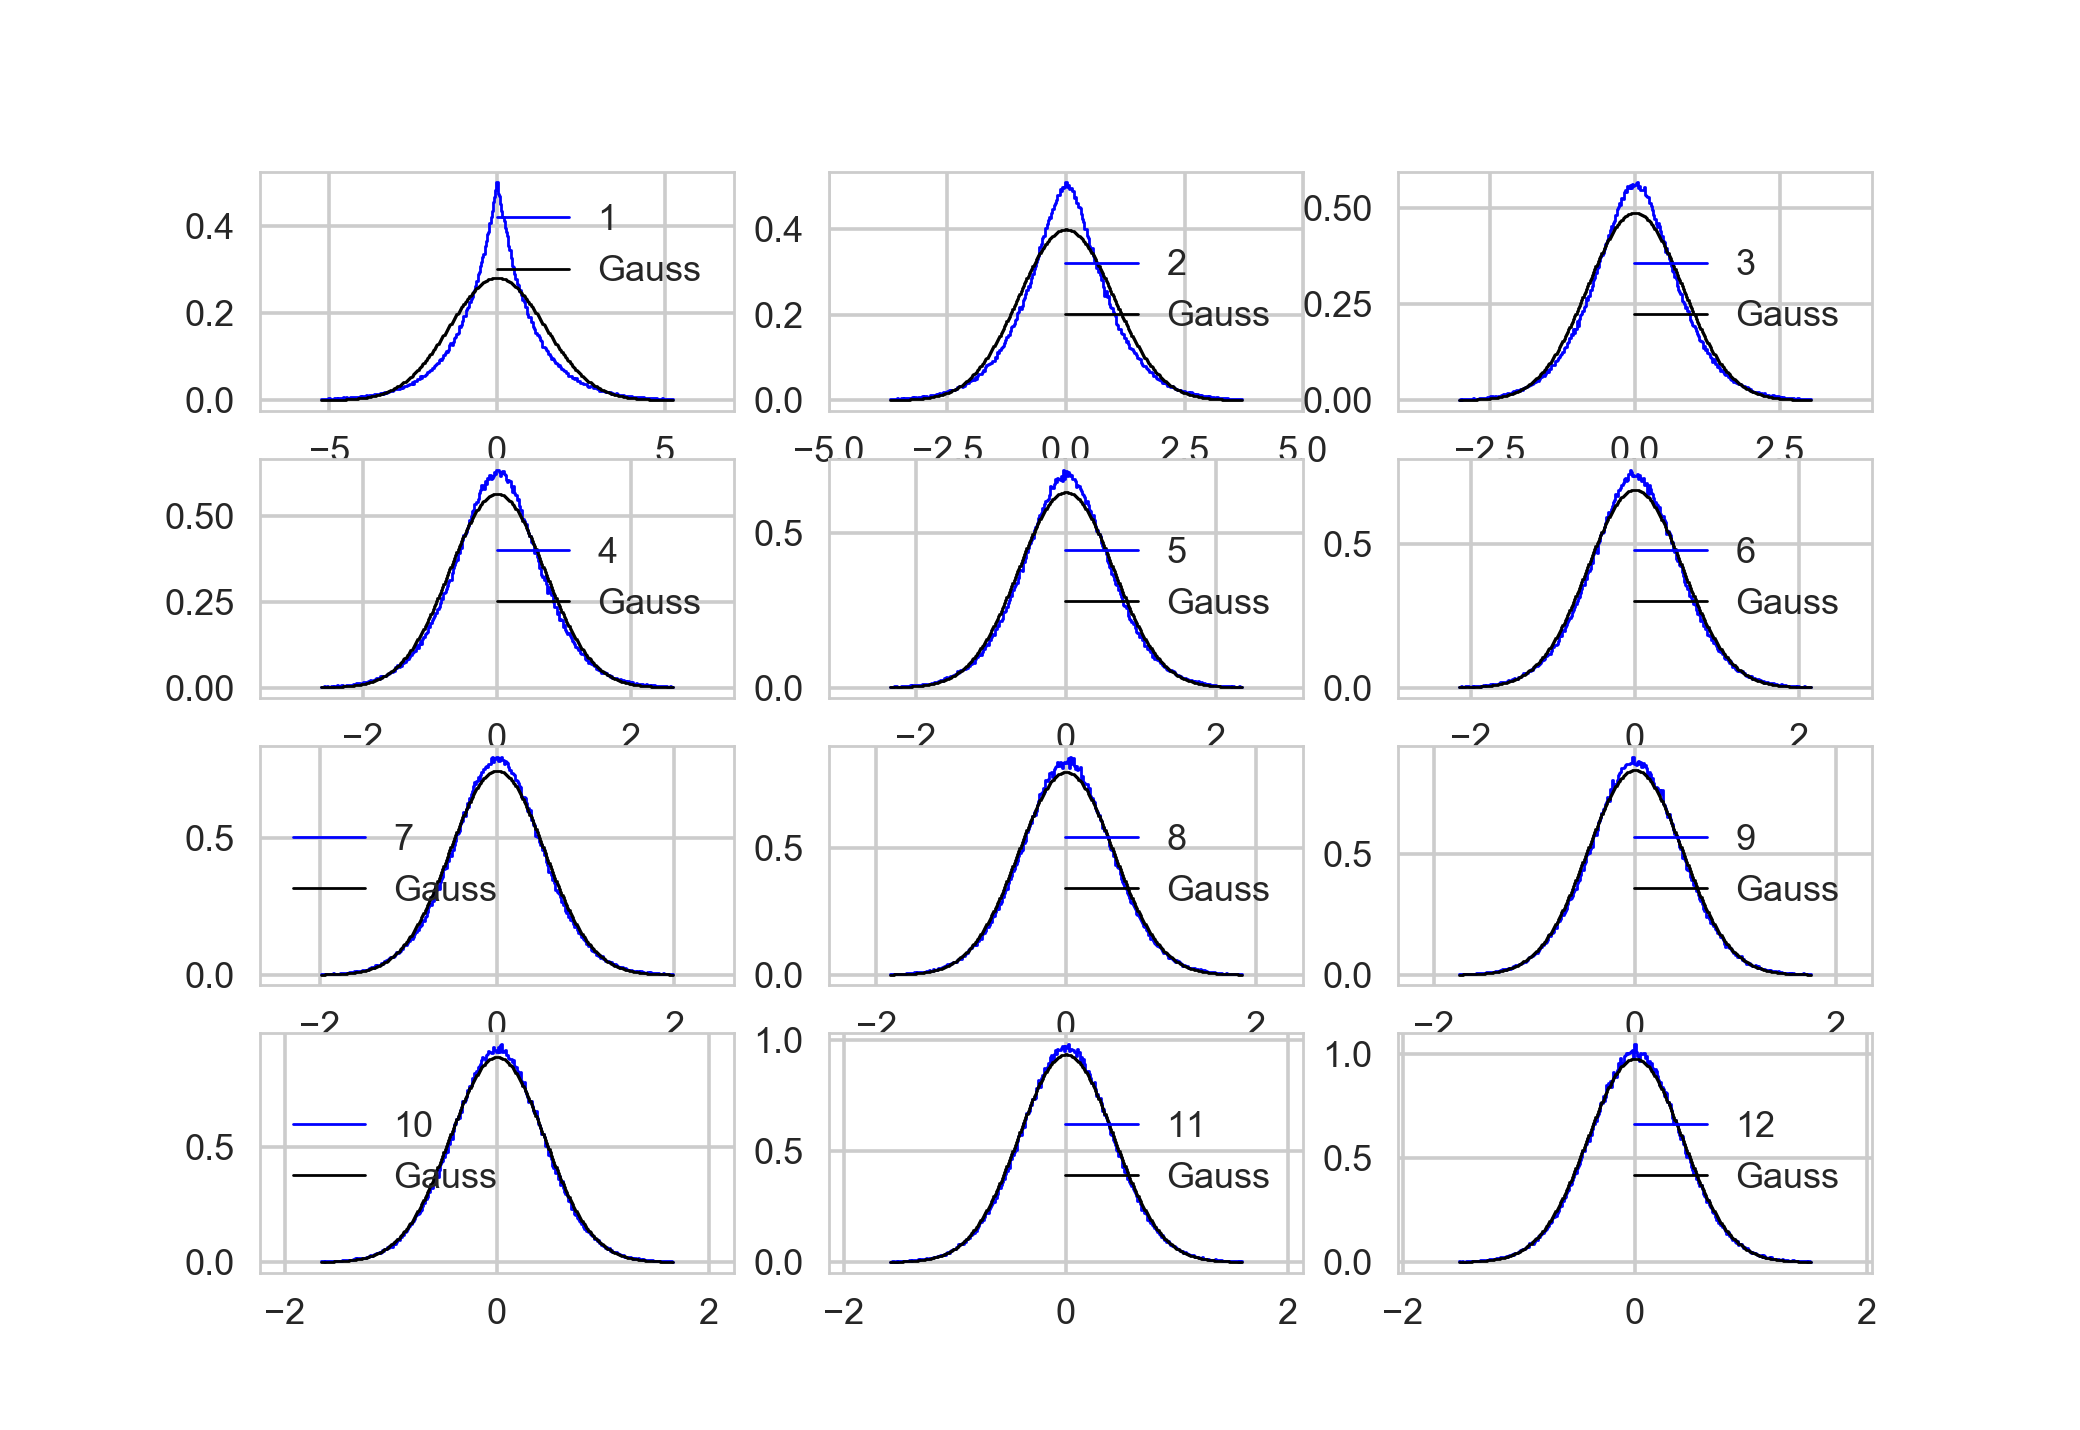

In [43]:
import matplotlib as mpl
import numpy.random as ra

import matplotlib.colors as colors
import matplotlib.cm as cmx
def rough_leahy_cpds(lc1, lc2, dt):
    assert len(lc1) == len(lc2), "Light curves must have the same length"
    nbin = len(lc1)
    nph1 = np.sum(lc1)
    nph2 = np.sum(lc2)
    nph = np.sqrt(nph1 * nph2)
    
    ft1 = np.fft.fft(lc1)
    ft2 = np.fft.fft(lc2)

    freq = np.fft.fftfreq(nbin, dt)
    good = freq > 0
    cpds = ft1 * ft2.conj()
    return freq[good], cpds[good] * 2 / nph

nrows = 4
ncols = 3
nplotmax = nrows * ncols
nmax = 61
values = np.arange(0, nmax)

total_cpds = 0
isfs_99 = []
gauss_isfs_99 = []
plot = True
if plot:
    fig = plt.figure(np.random.uniform(0, 1000))
    gs = mpl.gridspec.GridSpec(nrows, ncols)

p_values = np.logspace(-2, np.log10(60), 15)

probs_100 = 100 - p_values
plot_isfs = [0, 1, 2, 5, 9, 14, 29, 59]
isfs = {}

for i in values:
    # For cospectra, the expected sigma is not 2/sqrt(M), but sqrt(2)/sqrt(M) (Bachetti+15)
    exp_sigma = np.sqrt(2)/np.sqrt(i+1)
    gauss = scipy.stats.norm(0, exp_sigma)
    p9999 = gauss.isf(0.0001)

    row = np.int(i / ncols)
    col = i % ncols
    if plot and i < nplotmax:
        ax = plt.subplot(gs[row, col])
    
    lc1 = ra.poisson(10, 1000000)
    lc2 = ra.poisson(10, 1000000)

    freq, cpds = rough_leahy_cpds(lc1, lc2, dt)
    total_cpds += cpds
    
    local_ave = total_cpds / (i+1)
    
    hist_real, binx = np.histogram(local_ave.real, bins=np.linspace(-p9999, p9999, 300), normed=True)

    powers = (binx[1:] + binx[:-1]) / 2
    dp = np.diff(binx)

    if plot and i < nplotmax:
        ax.plot(powers, hist_real / np.sum(hist_real) / dp, drawstyle="steps-mid", color='b', lw=1, label=str(i+1))
        ax.plot(powers, gauss.pdf(powers), drawstyle="steps-mid", color='k', lw=1, label='Gauss')
        ax.set_xlim([-exp_sigma*5, exp_sigma * 5])
        ax.legend()


    isfs_99.append(np.percentile(local_ave.real, 99))
    gauss_isfs_99.append(gauss.ppf(0.99))
    if i in plot_isfs:
        isfs[i] = np.array([np.percentile(local_ave.real, p) for p in probs_100])

isfs_99 = np.asarray(isfs_99)
gauss_isfs_99 = np.asarray(gauss_isfs_99)

Here's a function that plots p-values:

In [44]:
def averaged_cospectra_cdf(xcoord, n):
    cdf = np.zeros_like(xcoord)

    for i,x in enumerate(xcoord):
        prefac_bottom1 = scipy.misc.factorial(n-1)
        #print("x: " + str(x))
        for j in range(n):
            #print("j: " + str(j))
            prefac_top = scipy.misc.factorial(n-1+j)
            prefac_bottom2 = scipy.misc.factorial(n-1-j) * scipy.misc.factorial(j)
            prefac_bottom3 = 2.0**(n+j)
            
            prefac = prefac_top / (prefac_bottom1 * prefac_bottom2 * prefac_bottom3)
            
            #print("prefac: " + str(prefac))
            gf = -j + n
            
            #print("gamma_fac: " + str(gf))
            first_fac = scipy.special.gamma(gf)
            #print("first_fac: " + str(first_fac))
            if x >= 0:    
                second_fac = scipy.special.gammaincc(gf, n*x) * first_fac
                #print("second_fac: " + str(second_fac))
                fac = 2.0*first_fac - second_fac
            else:
                fac = scipy.special.gammaincc(gf, -n*x) * first_fac
            
            #print("fac: " + str(fac))
            #print("prefac * fac: " + str(prefac*fac) + "\n")
            cdf[i] += (prefac * fac)
                
    return cdf
        

In [45]:
nave2 = isfs[2]

In [46]:
min_x = np.min(nave2)
max_x = np.max(nave2)

In [47]:
max_x

4.1123305201402047

In [48]:
xcoords = np.linspace(min_x, max_x, 20)

In [49]:
def plot_pvalues(isfs, p_values, idx, ax=None):

    nave = list(isfs.keys())[idx]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10,6), sharey=True)
    
    if nave == 0:
        ax.set_title('No averaging'.format(nave))
    else:
        ax.set_title('{} averaged spectra'.format(nave + 1))
    ax.set_ylabel('p-value')
    ax.set_xlabel('Power')

    exp_sigma = np.sqrt(2)/np.sqrt(nave+1)
    gauss = scipy.stats.norm(0, exp_sigma)
    
    xcoords = np.linspace(np.min(isfs[nave]), np.max(isfs[nave]), 1000)
    
    exact_dist = averaged_cospectra_cdf(xcoords, nave+1)

    ax.semilogy(isfs[nave], p_values / 100, label='Data', color="black")
    ax.semilogy(xcoords, gauss.sf(xcoords), linestyle="dashed", label="Gaussian", color="black")

    ax.semilogy(xcoords, 1.0-exact_dist, color="red", linestyle="dashed", label='Exact distribution')

    ax.legend()
    
    return ax
    

Let's make a nice plot for the paper.

<IPython.core.display.Javascript object>


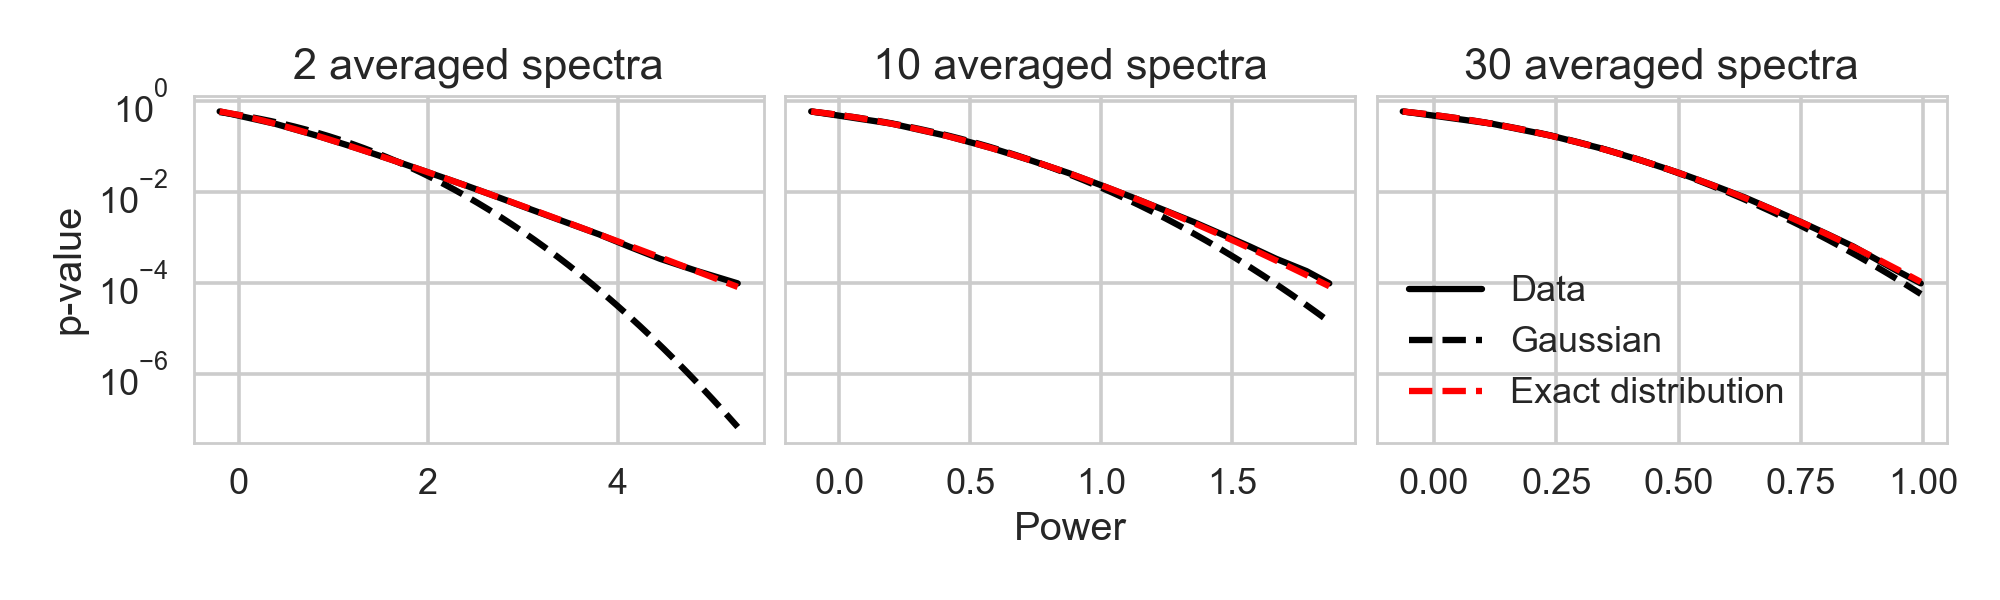

In [50]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3), sharey=True)

ax1 = plot_pvalues(isfs, p_values, 1, ax=ax1)
ax2 = plot_pvalues(isfs, p_values, 4, ax=ax2)
ax3 = plot_pvalues(isfs, p_values, 6, ax=ax3)

ax2.set_ylabel("")
ax3.set_ylabel("")
ax1.set_xlabel("")
ax3.set_xlabel("")

ax1.legend([])
ax2.legend([])

plt.tight_layout(w_pad=0.5)

plt.savefig("../paper/avg_pvalues.png", format="png")


And that looks like my theoretical distribution works! Woo!